In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import torch
from typing import Optional, Literal, Union
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

# we use a local copy of the fast_soft_sort manually downloaded from
# https://github.com/google-research/fast-soft-sort/tree/master
from fast_soft_sort.pytorch_ops import soft_rank

from help_spearman_proxy import *

## Load and prepare data

In [2]:
X_train_raw = pd.read_csv(r"../data/X_train.csv")
X_test_raw = pd.read_csv(r"../data/X_test.csv")
y_train = pd.read_csv(r"../data/y_train.csv")

The data is not standartized, but it was clearly processed in some way: 

<Axes: >

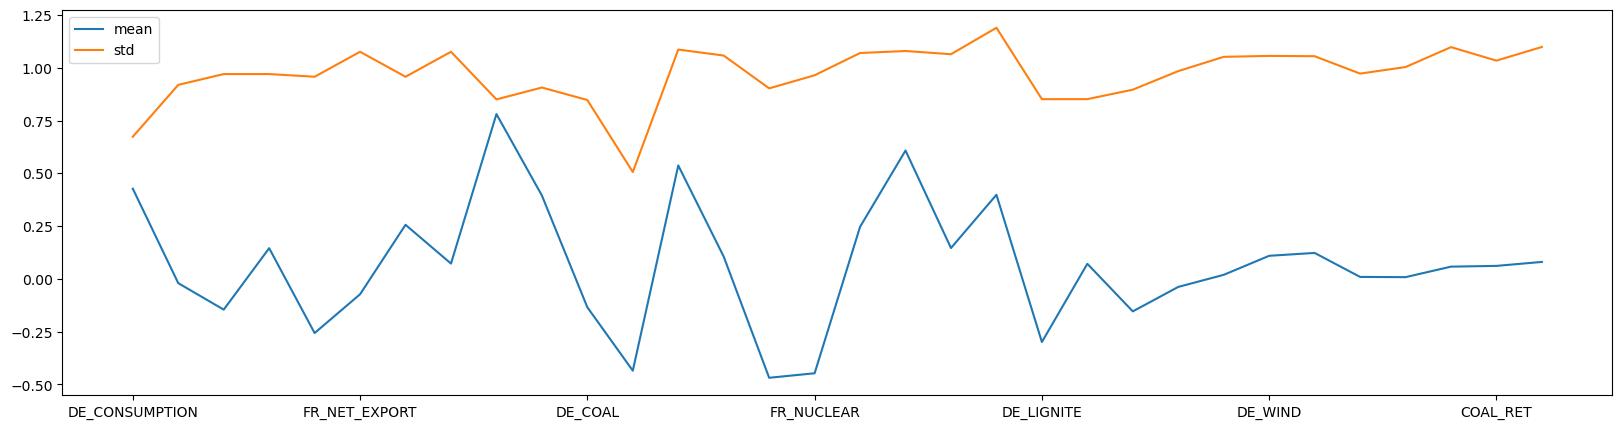

In [3]:
description = X_train_raw.drop(columns=["ID", "DAY_ID"]).describe()

fig, ax = plt.subplots(figsize=(20, 5))
description.T.drop(columns=["count", "min", "max", "25%", "50%", "75%"]).plot(ax=ax)

Mask data for FR and DE:

In [4]:
mask_train_FR = X_train_raw["COUNTRY"] == "FR"
mask_test_FR = X_test_raw["COUNTRY"] == "FR"

Drop unsuded cols:

In [5]:
columns_to_drop = ["ID", "DAY_ID", "COUNTRY", "DE_FR_EXCHANGE", "FR_NET_IMPORT", "DE_NET_IMPORT"]

X_train = X_train_raw.drop(columns_to_drop, axis=1)
X_test = X_test_raw.drop(columns_to_drop, axis=1)
y_train = y_train["TARGET"]

Standartize vars:

In [6]:
X_train = (X_train - X_train.mean()) / X_train.std()
X_test = (X_test - X_test.mean()) / X_test.std()

Fill-in NAs:

In [7]:
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

<Axes: >

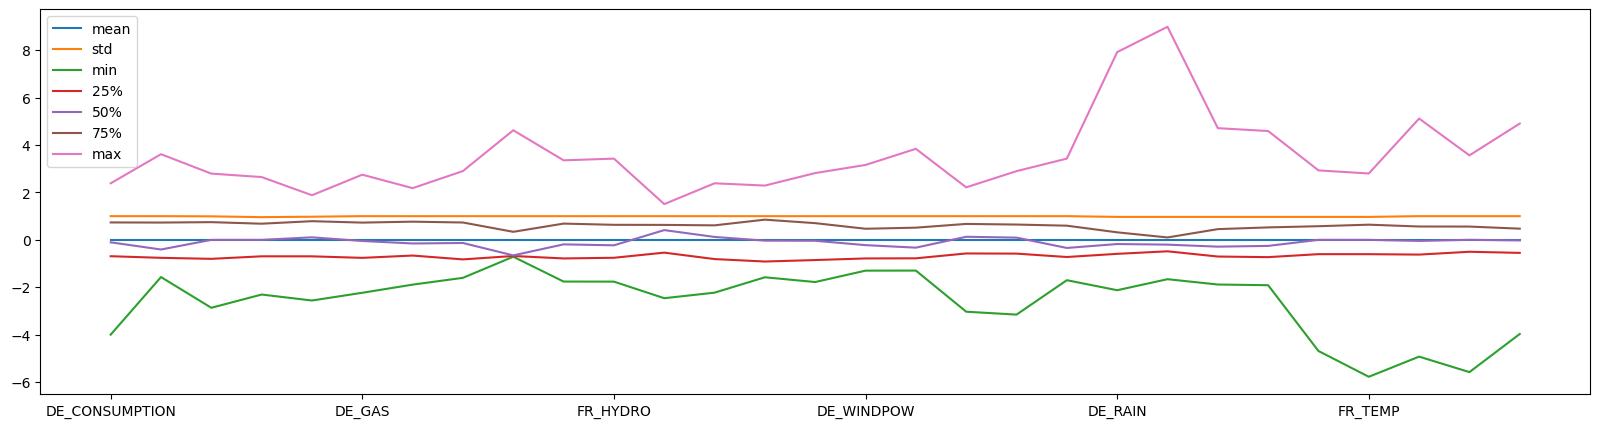

In [8]:
fig, ax = plt.subplots(figsize=(20, 5))
X_train.describe().T.drop(columns=["count"]).plot(ax=ax)

Convert to torch tensors:

In [9]:
X_train_th = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
y_train_th = torch.tensor(y_train.to_numpy(), dtype=torch.float32).reshape(-1, 1)

## Help funcs

In [10]:
eval_fns = \
    {
        "MSE": eval_mse,
        "hardMSRD": eval_hard_msrd,
        "softMSRD": eval_soft_msrd,
        "hardSpearman": eval_hard_spearman,
        "softSpearman": eval_soft_spearman
    }

## Objective: MSE, eval: MSE

CV grid search:

In [11]:
loss_fn = loss_mse
lr = 0.1

wds = [0., 0.1, 1., 5.]

eval_fns = \
    {
        "MSE": eval_mse,
        "hardSpearman": eval_hard_spearman
    }

stats = \
    {
        "wd": [],
        "loss mean train": [],
        "loss std train": [],
        "loss mean val": [],
        "loss std val": []
    }
for name in eval_fns:
    stats[name + " mean train"] = []
    stats[name + " std train"] = []
    stats[name + " mean val"] = []
    stats[name + " std val"] = []

for wd in wds:

    mean_loss, std_loss, mean_eval, std_eval = \
        cv_loop(X_train_th, y_train_th, loss_fn, lr, wd, eval_fns)
    
    # store stats
    stats["wd"].append(wd)
    stats["loss mean train"].append(mean_loss["train"])
    stats["loss std train"].append(std_loss["train"])
    stats["loss mean val"].append(mean_loss["val"])
    stats["loss std val"].append(std_loss["val"])
    for name in eval_fns:
        stats[name + " mean train"].append(mean_eval["train " + name])
        stats[name + " std train"].append(std_eval["val " + name])
        stats[name + " mean val"].append(mean_eval["train " + name])
        stats[name + " std val"].append(std_eval["val " + name])

stats = pd.DataFrame(stats)

In [12]:
stats

,wd,loss mean train,loss std train,loss mean val,loss std val,MSE mean train,MSE std train,MSE mean val,MSE std val,hardSpearman mean train,hardSpearman std train,hardSpearman mean val,hardSpearman std val
0,0.0,1.003053,0.050838,1.064890,0.212835,1.003053,0.212835,1.003053,0.212835,0.278653,0.050316,0.278653,0.050316
1,0.1,1.005183,0.050732,1.058707,0.211136,1.005183,0.211136,1.005183,0.211136,0.277506,0.053244,0.277506,0.053244
2,1.0,1.020346,0.050741,1.053988,0.210997,1.020346,0.210997,1.020346,0.210997,0.259749,0.056807,0.259749,0.056807
3,5.0,1.069545,0.054950,1.063079,0.231667,1.069545,0.231667,1.069545,0.231667,0.127777,0.059117,0.127777,0.059117


Train model with optimal params:

In [13]:
model, stats, stats_params = \
    train(
        X_train_th,
        y_train_th,
        X_train_th,
        y_train_th,
        n_steps=300,
        lr=0.1,
        weight_decay=0.0,
        loss_fn=loss_fn,
        eval_fns=eval_fns
        )

Final model params:
weight:	Parameter containing:
tensor([[-0.0499,  0.0992, -0.1733, -0.2794, -0.0805, -0.0423,  0.0288, -0.0359,
         -0.0166,  0.0510,  0.0382, -0.0063,  0.1580, -0.0429, -0.0841,  0.0146,
         -0.1225, -0.0415,  0.0481, -0.1645, -0.0176, -0.0238, -0.0556,  0.0871,
         -0.0166,  0.0015,  0.0277, -0.0178,  0.0150]], requires_grad=True)
bias:	Parameter containing:
tensor([0.0899], requires_grad=True)


Learning curves:

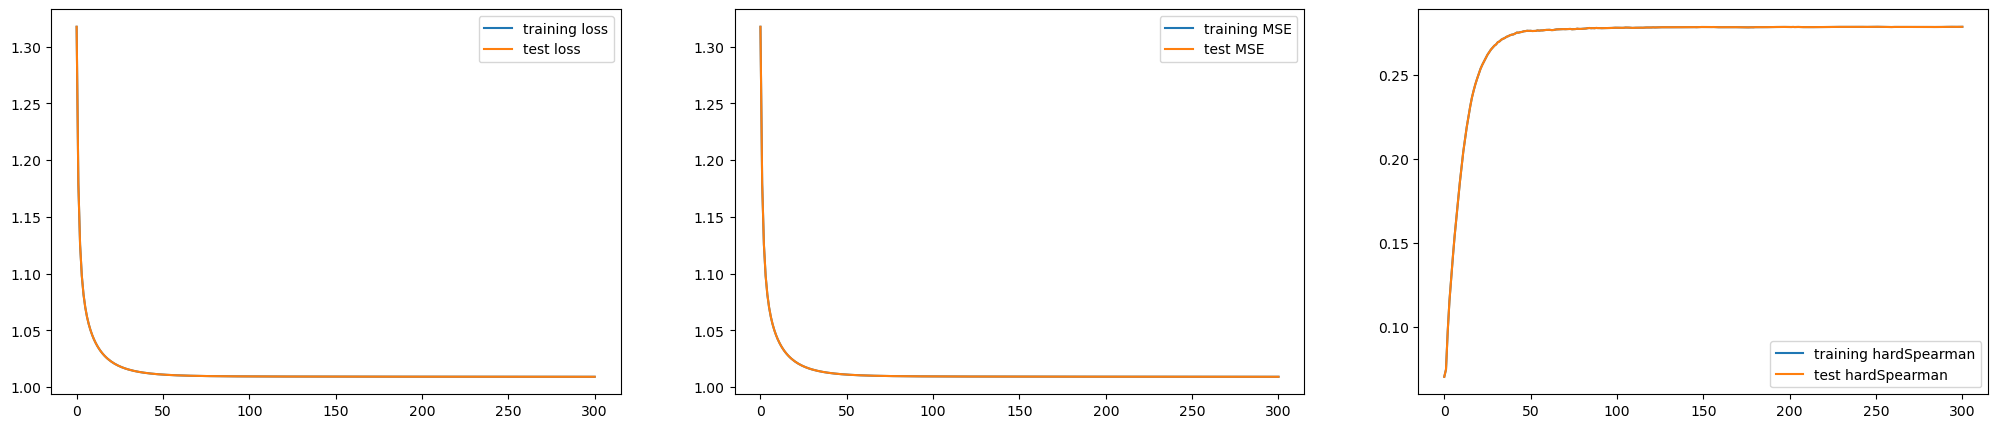

In [14]:
fig, axs = plt.subplots(nrows=1, ncols=(stats.shape[1] // 2), figsize=(25, 5))
for i, ax in enumerate(axs):
    stats.iloc[:, 2*i:2*i+2].plot(ax=ax)

Model parameters evolution:

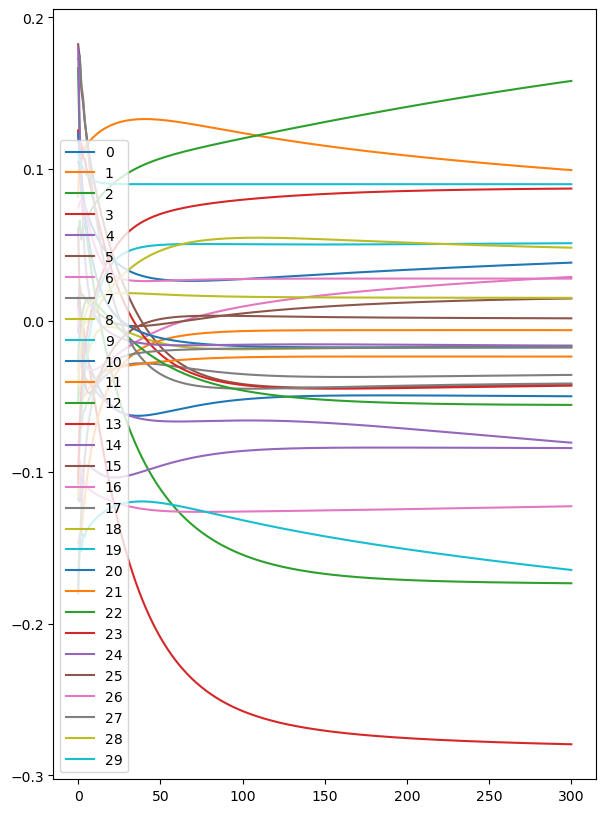

In [15]:
# fig, axs = plt.subplots()
ax1 = stats_params.plot(figsize=(7, 10))
# ax2 = ax1.twinx()
# ax2.plot(stats["training loss"])
# ax2.set_yscale('log')

Metrics vs params:

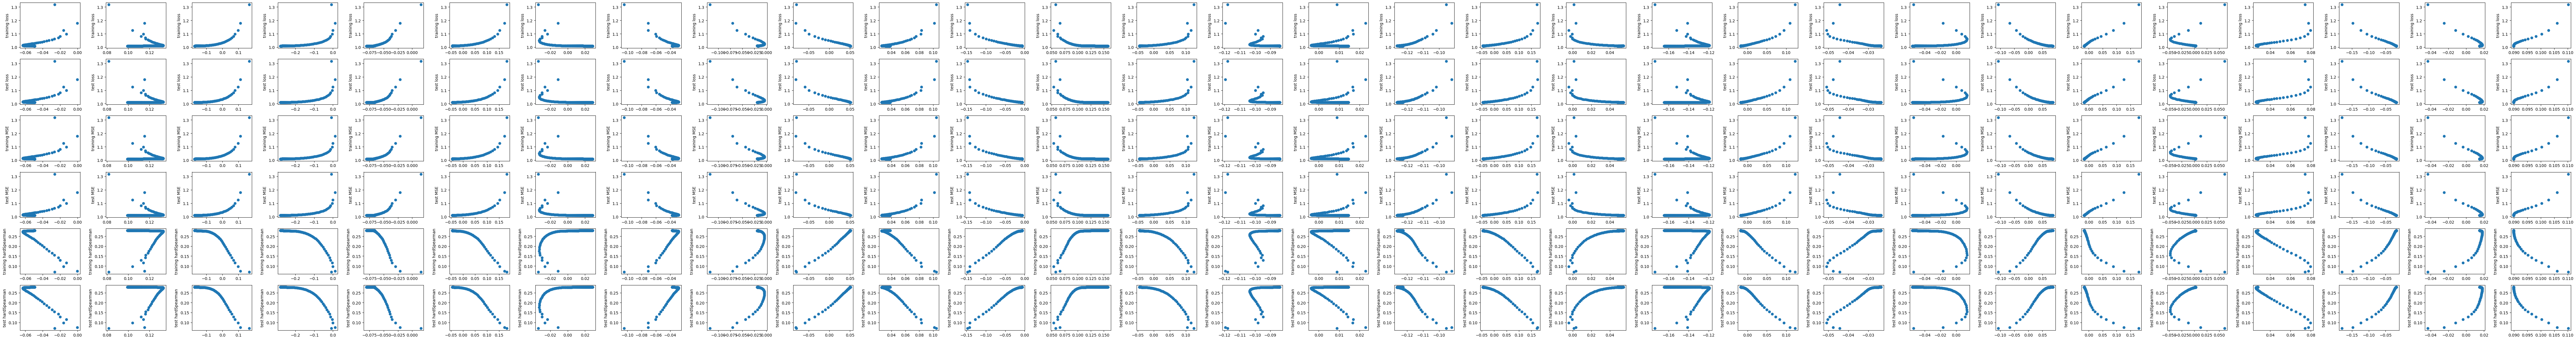

In [16]:
fig, axs = plt.subplots(nrows=stats.shape[1], ncols=stats_params.shape[1], sharex=False, figsize=(stats_params.shape[1]*3, stats.shape[1]*2))
for i in range(stats.shape[1]):
    for j in range(stats_params.shape[1]):
        axs[i, j].scatter(stats_params.iloc[:, j], stats.iloc[:, i])
        # axs[i, j].set_xlabel(j)
        axs[i, j].set_ylabel(stats.columns[i])
plt.tight_layout()
plt.show()

Spearman corr by eyes:

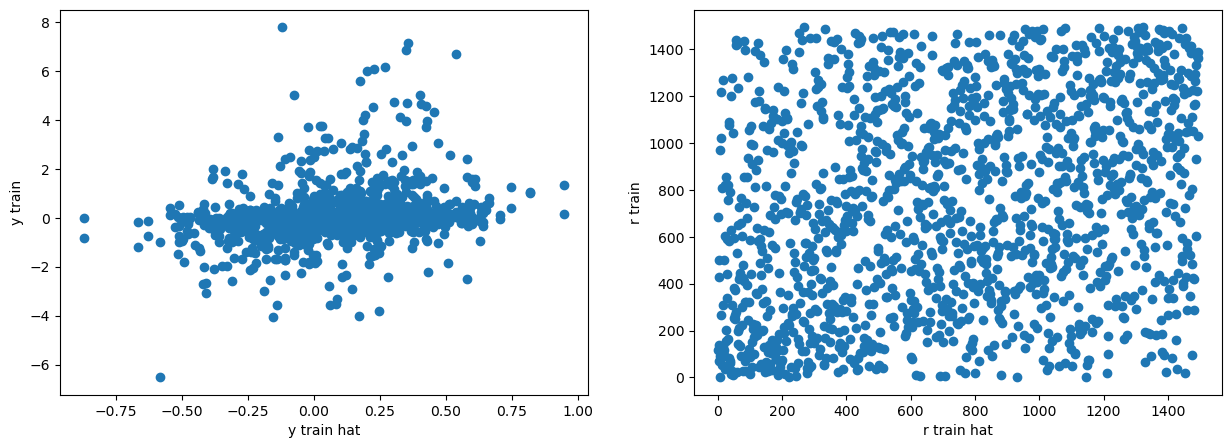

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].scatter(model(X_train_th).detach().numpy(), y_train_th.numpy())
axs[0].set_xlabel("y train hat")
axs[0].set_ylabel("y train")

axs[1].scatter(rank(model(X_train_th)).detach().numpy(), rank(y_train_th).numpy())
axs[1].set_xlabel("r train hat")
axs[1].set_ylabel("r train")

plt.show()

## Objective: MSRD, eval: exact MSRD

CV grid search:

In [18]:
loss_fn = loss_msrd
lr = 0.1

wds = [0., 0.1, 1., 5.]

eval_fns = \
    {
        "MSE": eval_mse,
        "hardSpearman": eval_hard_spearman
    }

stats = \
    {
        "wd": [],
        "loss mean train": [],
        "loss std train": [],
        "loss mean val": [],
        "loss std val": []
    }
for name in eval_fns:
    stats[name + " mean train"] = []
    stats[name + " std train"] = []
    stats[name + " mean val"] = []
    stats[name + " std val"] = []

for wd in wds:

    mean_loss, std_loss, mean_eval, std_eval = \
        cv_loop(X_train_th, y_train_th, loss_fn, lr, wd, eval_fns)
    
    # store stats
    stats["wd"].append(wd)
    stats["loss mean train"].append(mean_loss["train"])
    stats["loss std train"].append(std_loss["train"])
    stats["loss mean val"].append(mean_loss["val"])
    stats["loss std val"].append(std_loss["val"])
    for name in eval_fns:
        stats[name + " mean train"].append(mean_eval["train " + name])
        stats[name + " std train"].append(std_eval["val " + name])
        stats[name + " mean val"].append(mean_eval["train " + name])
        stats[name + " std val"].append(std_eval["val " + name])

stats = pd.DataFrame(stats)

In [19]:
stats

,wd,loss mean train,loss std train,loss mean val,loss std val,MSE mean train,MSE std train,MSE mean val,MSE std val,hardSpearman mean train,hardSpearman std train,hardSpearman mean val,hardSpearman std val
0,0.0,3.801459e-07,1.857314e-08,0.000024,0.000005,1.317522,0.261233,1.317522,0.261233,0.070403,0.087029,0.070403,0.087029
1,0.1,3.785821e-07,1.853407e-08,0.000024,0.000005,1.312059,0.260626,1.312059,0.260626,0.070402,0.087029,0.070402,0.087029
2,1.0,3.652804e-07,1.819897e-08,0.000023,0.000005,1.265687,0.255399,1.265687,0.255399,0.070405,0.087022,0.070405,0.087022
3,5.0,3.229811e-07,1.707256e-08,0.000020,0.000004,1.120247,0.237660,1.120247,0.237660,0.070401,0.087030,0.070401,0.087030


In [20]:
stats

,wd,loss mean train,loss std train,loss mean val,loss std val,MSE mean train,MSE std train,MSE mean val,MSE std val,hardSpearman mean train,hardSpearman std train,hardSpearman mean val,hardSpearman std val
0,0.0,3.801459e-07,1.857314e-08,0.000024,0.000005,1.317522,0.261233,1.317522,0.261233,0.070403,0.087029,0.070403,0.087029
1,0.1,3.785821e-07,1.853407e-08,0.000024,0.000005,1.312059,0.260626,1.312059,0.260626,0.070402,0.087029,0.070402,0.087029
2,1.0,3.652804e-07,1.819897e-08,0.000023,0.000005,1.265687,0.255399,1.265687,0.255399,0.070405,0.087022,0.070405,0.087022
3,5.0,3.229811e-07,1.707256e-08,0.000020,0.000004,1.120247,0.237660,1.120247,0.237660,0.070401,0.087030,0.070401,0.087030


Train model with optimal params:

In [21]:
model, stats, stats_params = \
    train(
        X_train_th,
        y_train_th,
        X_train_th,
        y_train_th,
        n_steps=3000,
        lr=lr,
        weight_decay=0.0,
        loss_fn=loss_fn,
        eval_fns=eval_fns
        )

Final model params:
weight:	Parameter containing:
tensor([[-0.0264,  0.0818,  0.1664, -0.0075,  0.0153,  0.1822, -0.0339, -0.1046,
         -0.1176, -0.0798,  0.1045, -0.1468,  0.0575,  0.1254, -0.1180,  0.0089,
         -0.0954,  0.1725,  0.0013, -0.1738,  0.1231, -0.0443, -0.0543, -0.1072,
          0.1797,  0.0606,  0.0743, -0.1799, -0.0431]], requires_grad=True)
bias:	Parameter containing:
tensor([0.1102], requires_grad=True)


Learning curves:

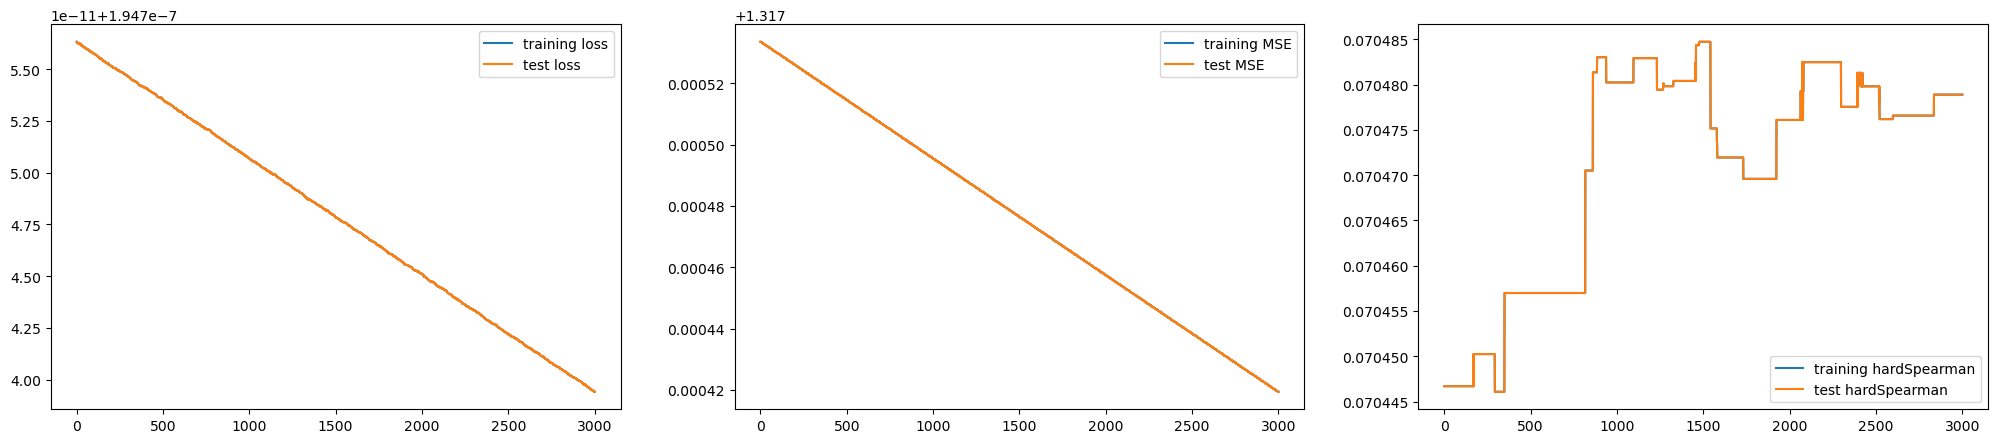

In [22]:
fig, axs = plt.subplots(nrows=1, ncols=(stats.shape[1] // 2), figsize=(25, 5))
for i, ax in enumerate(axs):
    stats.iloc[:, 2*i:2*i+2].plot(ax=ax)

Model parameters evolution:

<Axes: >

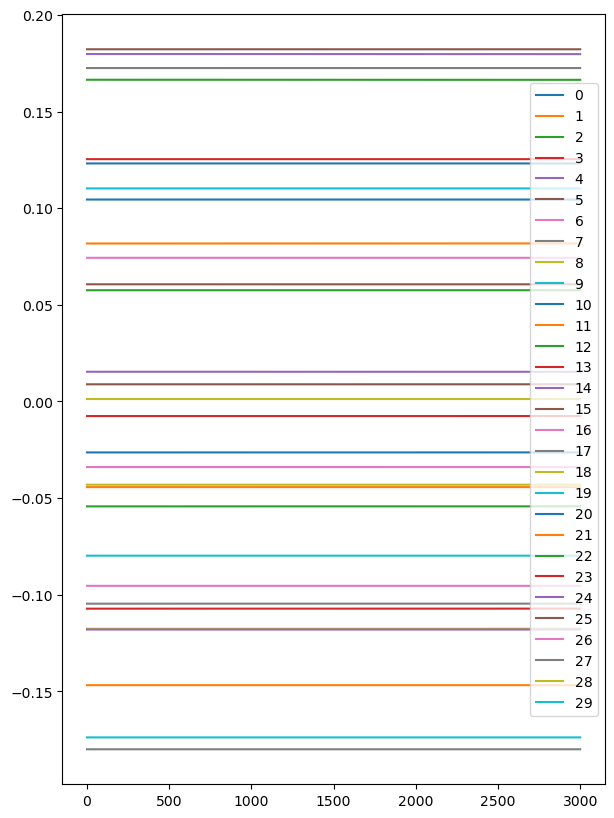

In [23]:
stats_params.plot(figsize=(7, 10))

Metrics vs params:

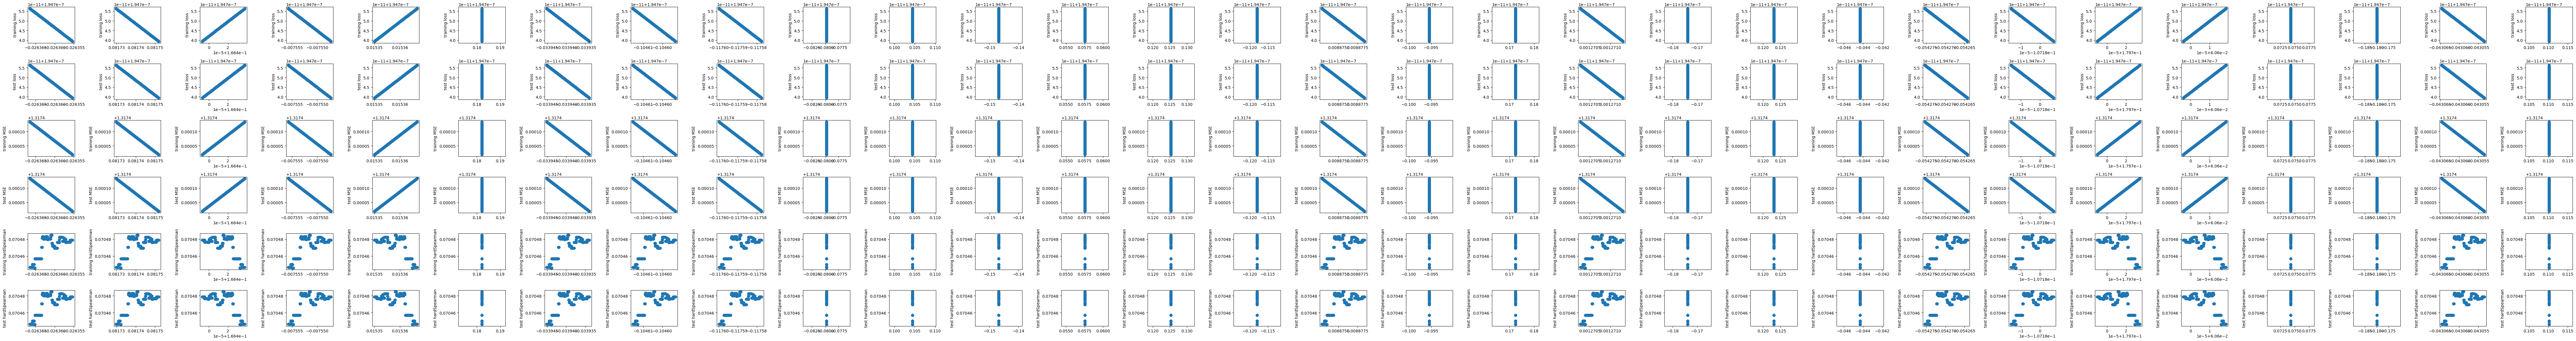

In [24]:
fig, axs = plt.subplots(nrows=stats.shape[1], ncols=stats_params.shape[1], sharex=False, figsize=(stats_params.shape[1]*3, stats.shape[1]*2))
for i in range(stats.shape[1]):
    for j in range(stats_params.shape[1]):
        axs[i, j].scatter(stats_params.iloc[:, j], stats.iloc[:, i])
        # axs[i, j].set_xlabel(j)
        axs[i, j].set_ylabel(stats.columns[i])
plt.tight_layout()
plt.show()

Spearman corr by eyes:

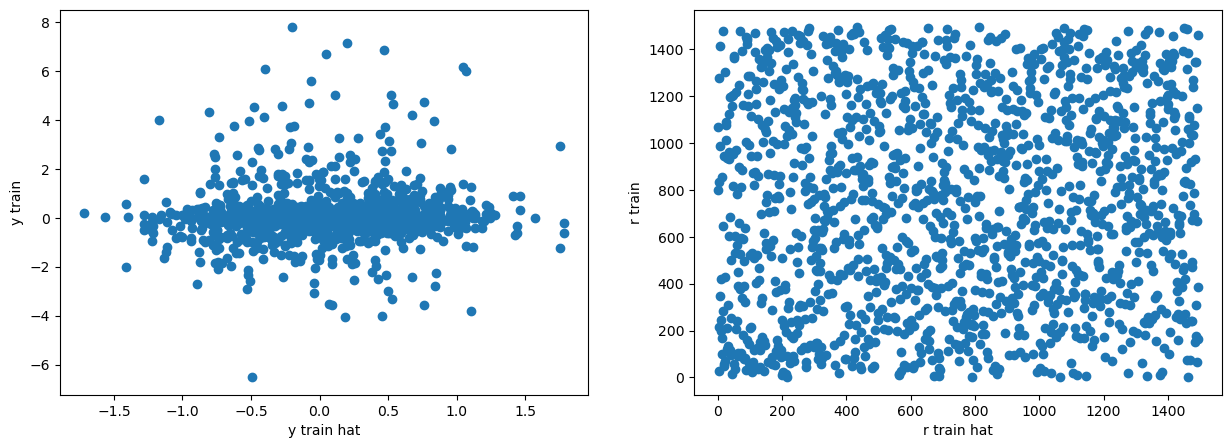

In [25]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].scatter(model(X_train_th).detach().numpy(), y_train_th.numpy())
axs[0].set_xlabel("y train hat")
axs[0].set_ylabel("y train")

axs[1].scatter(rank(model(X_train_th)).detach().numpy(), rank(y_train_th).numpy())
axs[1].set_xlabel("r train hat")
axs[1].set_ylabel("r train")

plt.show()

## Objective: Spearman

CV grid search:

In [26]:
loss_fn = loss_spearman
lr = 0.1

wds = [0., 0.1, 1., 5.]

eval_fns = \
    {
        "MSE": eval_mse,
        "hardSpearman": eval_hard_spearman
    }

stats = \
    {
        "wd": [],
        "loss mean train": [],
        "loss std train": [],
        "loss mean val": [],
        "loss std val": []
    }
for name in eval_fns:
    stats[name + " mean train"] = []
    stats[name + " std train"] = []
    stats[name + " mean val"] = []
    stats[name + " std val"] = []

for wd in wds:

    mean_loss, std_loss, mean_eval, std_eval = \
        cv_loop(X_train_th, y_train_th, loss_fn, lr, wd, eval_fns)
    
    # store stats
    stats["wd"].append(wd)
    stats["loss mean train"].append(mean_loss["train"])
    stats["loss std train"].append(std_loss["train"])
    stats["loss mean val"].append(mean_loss["val"])
    stats["loss std val"].append(std_loss["val"])
    for name in eval_fns:
        stats[name + " mean train"].append(mean_eval["train " + name])
        stats[name + " std train"].append(std_eval["val " + name])
        stats[name + " mean val"].append(mean_eval["train " + name])
        stats[name + " std val"].append(std_eval["val " + name])

stats = pd.DataFrame(stats)

In [26]:
stats

,wd,loss mean train,loss std train,loss mean val,loss std val,MSE mean train,MSE std train,MSE mean val,MSE std val,hardSpearman mean train,hardSpearman std train,hardSpearman mean val,hardSpearman std val
0,0.0,0.751346,0.014052,0.860702,0.049242,1.007236,0.205623,1.007236,0.205623,0.278488,0.049878,0.278488,0.049878
1,0.1,0.754171,0.014100,0.865824,0.044000,1.008380,0.216689,1.008380,0.216689,0.274717,0.050823,0.274717,0.050823
2,1.0,0.837930,0.084699,0.840256,0.057749,1.078470,0.226379,1.078470,0.226379,0.193742,0.064595,0.193742,0.064595
3,5.0,0.913195,0.043399,1.022555,0.066236,1.083047,0.221991,1.083047,0.221991,0.088519,0.049911,0.088519,0.049911


Train model with optimal params:

In [13]:
model, stats, stats_params = \
    train(
        X_train_th,
        y_train_th,
        X_train_th,
        y_train_th,
        n_steps=3000,
        lr=lr,
        weight_decay=0.0,
        loss_fn=loss_fn,
        eval_fns=eval_fns
        )

Final model params:
weight:	Parameter containing:
tensor([[-5.4272e-02,  1.0228e-01, -2.1584e-01, -3.4854e-01, -1.4787e-01,
         -4.9439e-02,  6.5815e-02, -4.2635e-02, -1.5787e-02,  6.5333e-02,
          6.9033e-02, -9.5749e-03,  2.7516e-01, -5.4022e-02, -1.0539e-01,
          2.2762e-03, -1.4395e-01, -4.9026e-02,  3.7145e-02, -2.8673e-01,
         -2.0668e-02, -2.8849e-02, -6.6949e-02,  1.0690e-01, -2.3146e-02,
          7.9839e-05,  3.3392e-02, -2.1339e-02,  1.7909e-02]],
       requires_grad=True)
bias:	Parameter containing:
tensor([0.1102], requires_grad=True)


Learning curves:

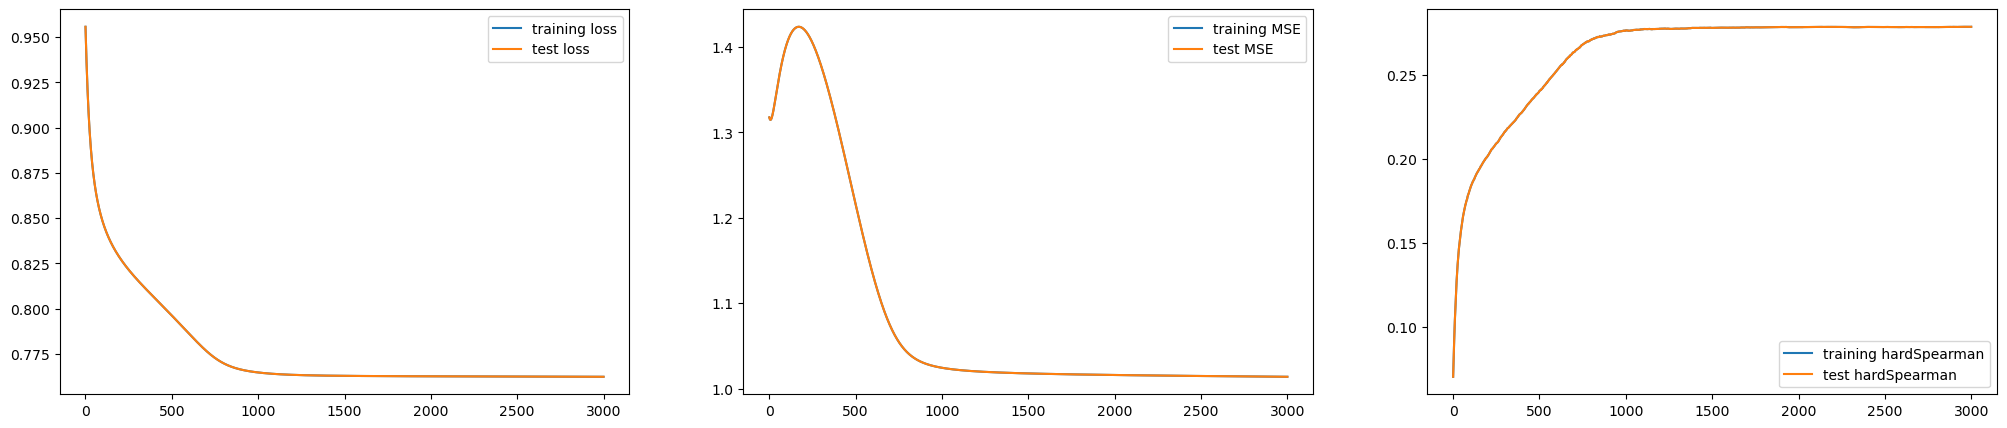

In [28]:
fig, axs = plt.subplots(nrows=1, ncols=(stats.shape[1] // 2), figsize=(25, 5))
for i, ax in enumerate(axs):
    stats.iloc[:, 2*i:2*i+2].plot(ax=ax)

Model parameters evolution:

<Axes: >

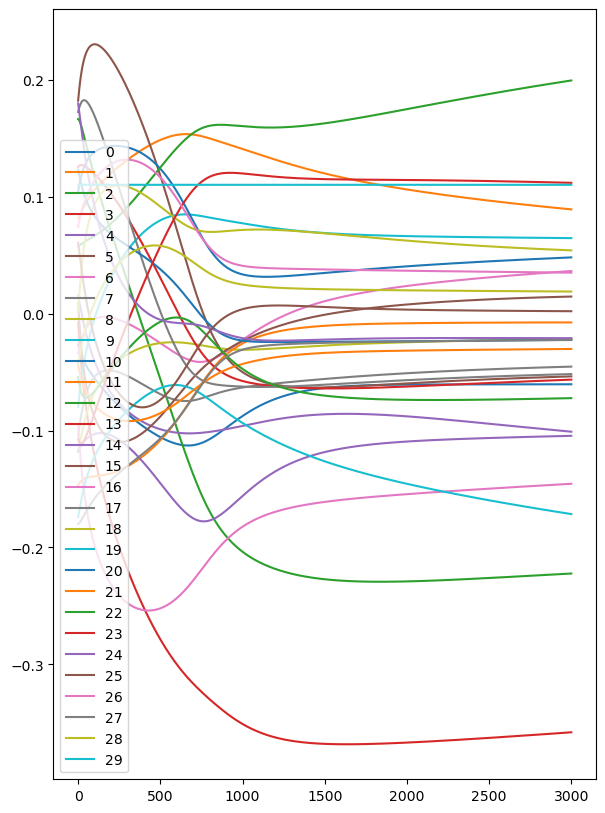

In [29]:
stats_params.plot(figsize=(7, 10))

Metrics vs params:

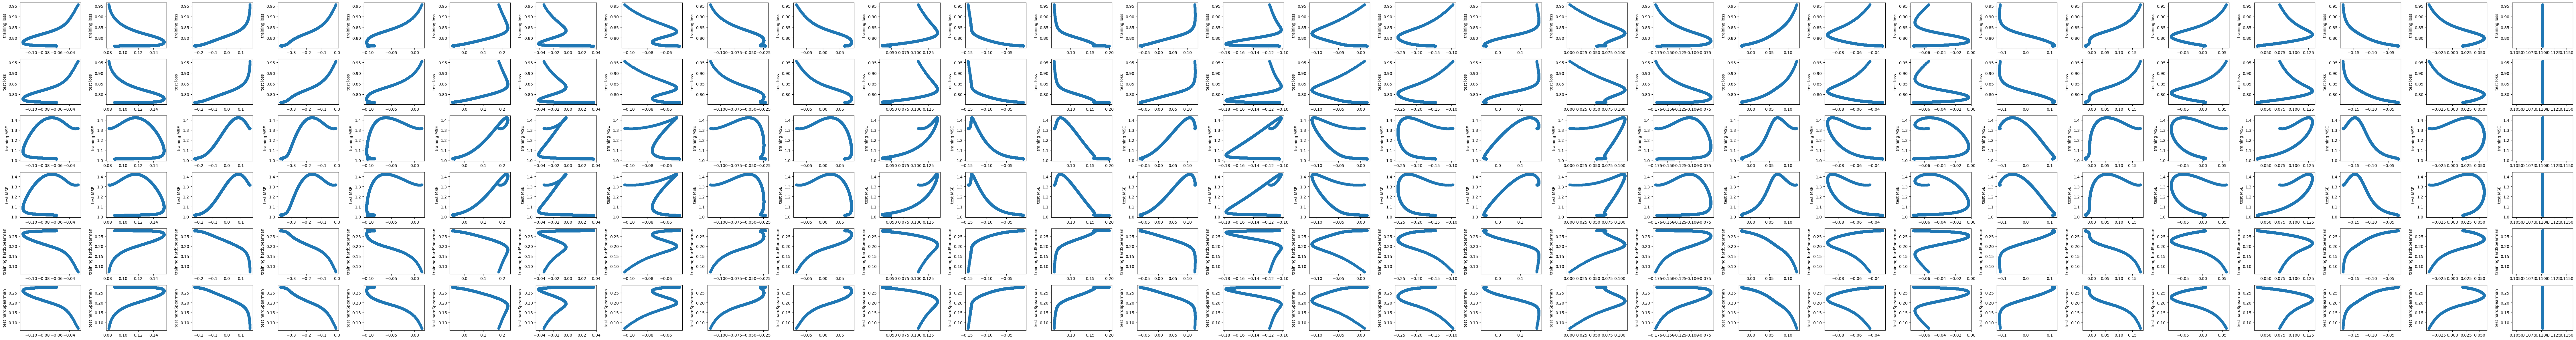

In [30]:
fig, axs = plt.subplots(nrows=stats.shape[1], ncols=stats_params.shape[1], sharex=False, figsize=(stats_params.shape[1]*3, stats.shape[1]*2))
for i in range(stats.shape[1]):
    for j in range(stats_params.shape[1]):
        axs[i, j].scatter(stats_params.iloc[:, j], stats.iloc[:, i])
        # axs[i, j].set_xlabel(j)
        axs[i, j].set_ylabel(stats.columns[i])
plt.tight_layout()
plt.show()

Spearman corr by eyes:

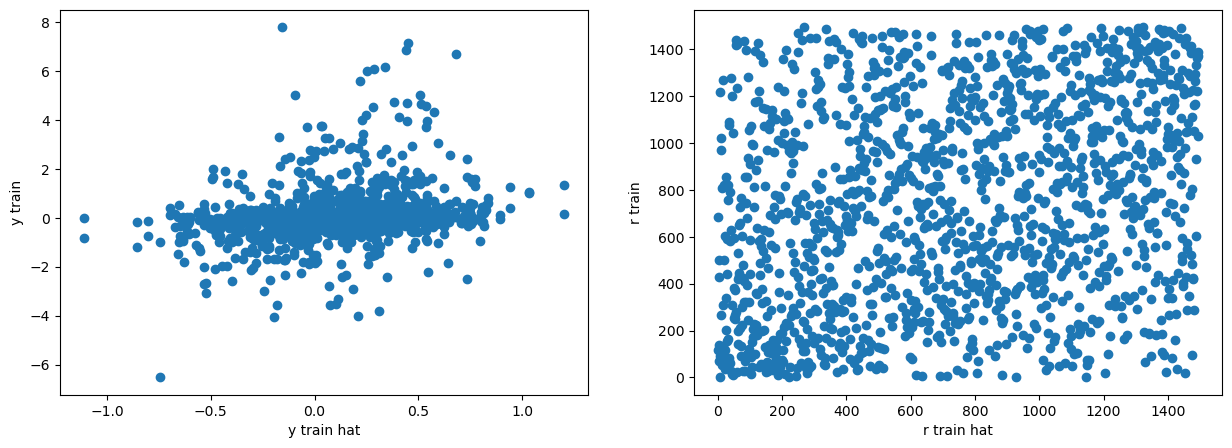

In [31]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].scatter(model(X_train_th).detach().numpy(), y_train_th.numpy())
axs[0].set_xlabel("y train hat")
axs[0].set_ylabel("y train")

axs[1].scatter(rank(model(X_train_th)).detach().numpy(), rank(y_train_th).numpy())
axs[1].set_xlabel("r train hat")
axs[1].set_ylabel("r train")

plt.show()